# Alpha gridsearch

In [ ]:
!pip install --upgrade seaborn

In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import fnmatch
import os
import matplotlib.pyplot as plt

In [152]:
# Define the parent folder and the subfolder naming pattern
experiment_folder = "./alpha_gridsearch"
subfolder_pattern = "run_*_*_*"

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the subfolders and read each CSV file into a dataframe
for subfolder_name in os.listdir(experiment_folder):
    if fnmatch.fnmatch(subfolder_name, subfolder_pattern):
        #parse score dataframe
        csv_path = os.path.join(experiment_folder, subfolder_name, "*.csv")
        score_file = f"{experiment_folder}/{subfolder_name}/{subfolder_name}.out"
        df = pd.read_csv(score_file, header=None, sep=" ", names=["family", "sp", "modeler", "tc", "col", "time"])
        assert df.shape[0] == 30
        for score in ["sp", "modeler", "tc", "col"]:
            assert df[score].isna().sum() == 0
        #keep track of corresponding alphas 
        for alpha_name, alpha_str in zip(["alpha_flank", "alpha_single", "alpha_global"], subfolder_name.split("_")[1:]):
            df[alpha_name] = float(alpha_str)
        dfs.append(df)

# Concatenate the dataframes into a single dataframe
result_df = pd.concat(dfs, ignore_index=True)

In [153]:
result_df

,family,sp,modeler,tc,col,time,alpha_flank,alpha_single,alpha_global
0,PF00450.10000.fasta,80.6,82.8,48.7,62.1,NaN,0.0,100000.0,0.0
1,PF13393.10000.fasta,43.9,45.1,2.9,4.5,NaN,0.0,100000.0,0.0
2,PF00476.10000.fasta,94.1,95.9,79.5,83.2,NaN,0.0,100000.0,0.0
3,PF00625.10000.fasta,41.5,43.2,4.5,7.2,NaN,0.0,100000.0,0.0
4,PF00078.10000.fasta,87.1,91.1,78.2,79.0,NaN,0.0,100000.0,0.0
...,...,...,...,...,...,...,...,...,...
7555,PF00018.10000.fasta,84.8,87.2,0.0,0.0,NaN,100.0,10000000.0,100000.0
7556,PF03129.10000.fasta,96.1,97.0,53.1,58.1,NaN,100.0,10000000.0,100000.0
7557,PF00037.10000.fasta,88.0,89.9,69.0,72.6,NaN,100.0,10000000.0,100000.0
7558,PF07686.10000.fasta,89.1,90.4,12.1,13.8,NaN,100.0,10000000.0,100000.0


In [154]:
groups = result_df.groupby(["alpha_flank", "alpha_single", "alpha_global"]).sp.mean().sort_values(ascending=False)
groups

alpha_flank  alpha_single  alpha_global
1000.0       1.000000e+09  100.0           79.206667
10.0         1.000000e+05  10.0            79.033333
100.0        0.000000e+00  100000.0        79.010000
             1.000000e+09  10000.0         78.973333
10.0         1.000000e+03  0.0             78.940000
                                             ...    
20000.0      1.000000e+05  1000.0          76.000000
             1.000000e+07  0.0             75.996667
0.0          1.000000e+01  10.0            75.840000
             0.000000e+00  10.0            75.566667
10.0         0.000000e+00  100.0           75.510000
Name: sp, Length: 252, dtype: float64

In [155]:
#default values so far:
groups.loc[7000.0, 1.000000e+09, 1e4]

76.87666666666668

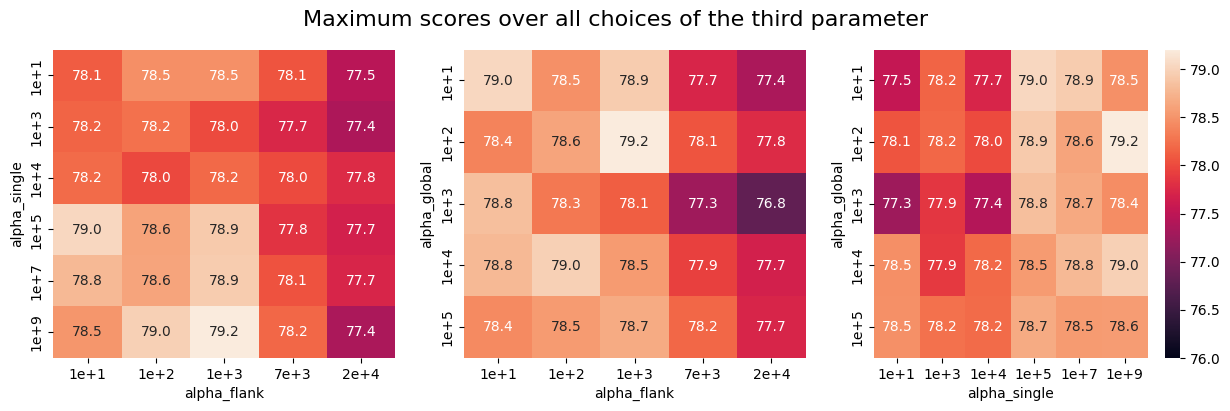

In [157]:
groups_df = groups.reset_index()
alphas = ["alpha_flank", "alpha_single", "alpha_global"]
#remove zero alphas for better visualization
groups_df[alphas] = groups_df[alphas][groups_df[alphas] > 0]
groups_df = groups_df.dropna()
for alpha in alphas:
    groups_df["log10_"+alpha] = np.log10(groups_df[alpha])
    
def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e+' + a.split('e+')[1].lstrip('0')

def get_labels(alpha):
    alpha_values = groups_df[alpha].unique()
    alpha_values.sort()
    return [format_e(x) for x in alpha_values]    
    
f, axes = plt.subplots(1, 3)
f.set_size_inches(15, 4)
f.suptitle("Maximum scores over all choices of the third parameter", fontsize=16)
for i, alpha_names in enumerate([["alpha_flank", "alpha_single"], 
                                ["alpha_flank", "alpha_global"], 
                                ["alpha_single", "alpha_global"]]):
    two_alpha_groups = groups_df.groupby(alpha_names).sp.max().reset_index()
    heatmap_df = two_alpha_groups.pivot(columns=alpha_names[0], index=alpha_names[1], values="sp")
    s = sns.heatmap(heatmap_df, 
                    cmap="rocket", 
                    ax=axes[i], 
                    annot=True, 
                    fmt=".1f",
                    xticklabels=get_labels(alpha_names[0]), 
                    yticklabels=get_labels(alpha_names[1]),
                    vmin=groups_df.sp.min(),
                    vmax=groups_df.sp.max(),
                    cbar=i==2)